<a href="https://colab.research.google.com/github/Rawab/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
person_data = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

# Manually checking for odd/missing values

for i in person_data:
  print(person_data[i].unique())
  

In [79]:
print(person_data.loc[5:10])
print(a, b, c, d)

    Unnamed: 0  age  weight  exercise_time
5            5   58     103            165
6            6   55     161            107
7            7   21     188             37
8            8   55     216             79
9            9   50     127            267
10          10   21     160            228
Unnamed: 0 age weight exercise_time


In [0]:
# Using color to distinguish by ages and grouping by age group
colors = []
preA, youngA = [[],[], 'yellow', 'Pre-Adult'], [[],[], 'orange', 'Young Adult']
midA, oldA = [[],[], 'red', 'Middle Aged'], [[],[], 'black', 'Elderly']
for i in range(len(person_data['age'])):
  a = person_data['age'][i]
  w = person_data['weight'][i]
  e = person_data['exercise_time'][i]
  
  if a < 20:
    colors.append('yellow')
    preA[0].append(e)
    preA[1].append(w)
  elif a < 40:
    colors.append('orange')
    youngA[0].append(e)
    youngA[1].append(w)
  elif a < 60:
    colors.append('red')
    midA[0].append(e)
    midA[1].append(w)
  else:
    colors.append('black')
    oldA[0].append(e)
    oldA[1].append(w)

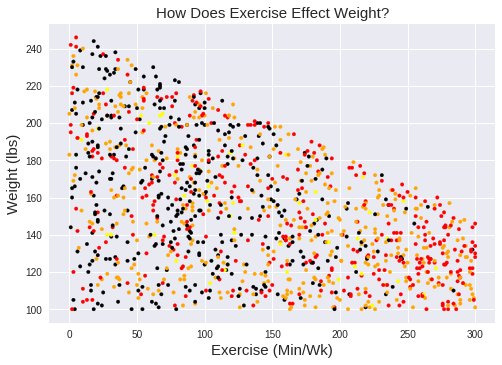

In [103]:
# Expect exercise time to influence weight

fig_1, ax_1 = plt.subplots()

ax_1.scatter(person_data['exercise_time'], person_data['weight'],
             c=colors, marker ='.')
ax_1.set_xlabel('Exercise (Min/Wk)', fontsize = 15)
ax_1.set_ylabel('Weight (lbs)', fontsize = 15)
ax_1.set_title('How Does Exercise Effect Weight?', fontsize = 15)
plt.show();

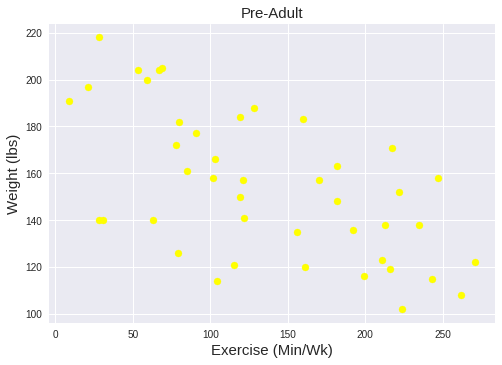

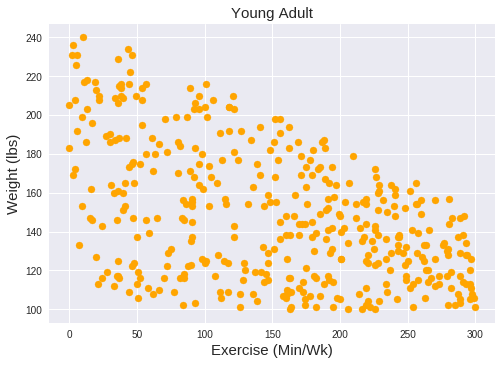

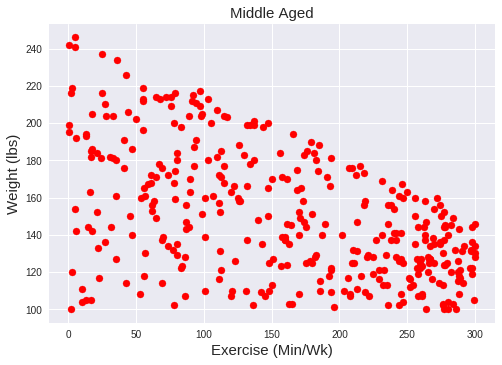

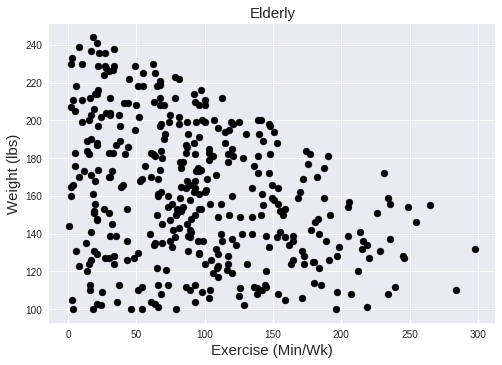

In [114]:
# Creating a function to produce plots by age group
def ProducePlot(age_group):
  fig, ax = plt.subplots()
  ax.scatter(age_group[0], age_group[1], c=age_group[2])
  ax.set_xlabel('Exercise (Min/Wk)', fontsize = 15)
  ax.set_ylabel('Weight (lbs)', fontsize = 15)
  ax.set_title(age_group[3], fontsize = 15)
  plt.show();
  
# It may be easier to see patterns by age group
for age_group in [preA, youngA, midA, oldA]:
  ProducePlot(age_group)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
**All of the variables are quantitative. In reality, all three variables are continuous. However, the data provided presents the values as integers. This is not an issue, as the large range of the variables allow us to treat them as continuous.**
2.  What are the relationships between the variables?
**It was expected that exercise time influenced weight. From the visualization, it is obvious there is certainly a negative correlation. However, there are fair amounts of middle-aged people who don't exercise much but still don't weigh too much.  **

> **Middle-aged people (40< and <60) choose to exercise more (Red). Elderly people (60<) choose to exercise less (Black). This information could be misinterpreted to suggest as people above the age of 40 age, they gain weight. **




3.  Which relationships are "real", and which spurious?
**Regardless of age group, it is reasonable to suggest weight is negatively influenced by exercise. It is not unreasonable to suggest age influences how much people choose to exercise.**

> **On the other hand, suggesting age influences weight is inappropriate, as exercise time is a confounding variable connecting these two variables.**



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)